# Air Quality Prediction Using Machine Learning
**Author:** Jahid Md Hasan 

---

## Project Overview
This notebook follows the complete **ML Project Lifecycle**:
1. Environment Setup
2. Data Understanding & EDA
3. Data Preprocessing
4. Feature Engineering
5. Model Development (Random Forest + Prophet + LSTM)
6. Model Evaluation
7. Future Forecasting (1 Week Ahead)
8. Interactive Dashboard (detailed visualizations)

**Target Variable:** `pm2_5` (PM2.5 — the most critical air quality indicator)

---

## Step 1: Environment Setup
Install and import all required libraries. We use:
- `pandas`, `numpy` for data manipulation
- `matplotlib`, `seaborn`, `plotly` for visualization
- `scikit-learn` for ML models and preprocessing
- `prophet` for time-series forecasting
- `tensorflow/keras` for LSTM deep learning model

In [2]:
# Install required libraries (run once in Colab)
!pip install prophet plotly ipywidgets -q

In [3]:
# ------- Core Libraries --------------------------
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#---- Visualization --------------------
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#------- Machine Learning -------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

#------ Forecasting ----------------------
from prophet import Prophet

#------------ Deep Learning (LSTM) -------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#----------- Style Config ------------------------
sns.set_theme(style='darkgrid', palette='viridis')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 12

print('All libraries imported successfully!')
print(f'   TensorFlow version: {tf.__version__}')
print(f'   Pandas version: {pd.__version__}')

All libraries imported successfully!
   TensorFlow version: 2.19.0
   Pandas version: 2.2.2



##  Step 2: Data Understanding & Exploratory Data Analysis (EDA)

We start by loading the dataset and exploring its structure, statistics, and distributions.
The dataset contains **daily air quality measurements** across multiple Indian cities with pollutants:
`CO, NO, NO2, O3, SO2, PM2.5, PM10, NH3` and an AQI label.

In [18]:
#dataset link
#https://archive.ics.uci.edu/dataset/360/air+quality

In [4]:
# --------Loading Dataset----------------
# from google.colab import files
# uploaded = files.upload()  # uncomment to upload manually

df = pd.read_csv('air_pollution_data.csv')

print('=' * 55)
print('         DATASET OVERVIEW')
print('=' * 55)
print(f'Shape        : {df.shape[0]:,} rows × {df.shape[1]} columns')
print(f'Columns      : {list(df.columns)}')
print(f'Date range   : {df["date"].min()} → {df["date"].max()}')
print(f'Cities       : {df["city"].nunique()} unique cities')
print('=' * 55)
df.head(10)

         DATASET OVERVIEW
Shape        : 23,504 rows × 11 columns
Columns      : ['city', 'date', 'aqi', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
Date range   : 01-01-2021 → 31-12-2022
Cities       : 26 unique cities


,city,date,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,Ahmedabad,30-11-2020,5,520.71,2.38,16.28,130.18,47.68,65.96,72.13,8.36
1,Ahmedabad,01-12-2020,5,1682.28,7.71,54.84,0.73,21.70,120.95,154.53,27.36
2,Ahmedabad,02-12-2020,5,1815.80,16.54,49.35,0.17,23.84,133.47,172.63,28.12
3,Ahmedabad,03-12-2020,5,2296.45,41.57,40.10,0.00,35.76,150.37,202.15,36.48
4,Ahmedabad,04-12-2020,5,2189.64,23.92,58.95,0.02,28.13,160.79,205.80,40.53
5,Ahmedabad,05-12-2020,5,3845.22,57.22,137.09,0.00,110.63,249.51,322.46,178.34
6,Ahmedabad,06-12-2020,5,2883.91,27.94,98.71,0.02,84.88,232.03,281.96,96.26
7,Ahmedabad,07-12-2020,5,1628.88,19.89,40.10,0.02,21.22,106.27,143.12,31.67
8,Ahmedabad,08-12-2020,5,1735.69,9.28,59.63,0.59,25.99,122.37,163.42,43.06
9,Ahmedabad,09-12-2020,5,2857.21,34.87,69.92,0.00,46.25,213.63,276.18,58.77


In [5]:
# ── Data Types & Basic Stats ──────────────────────────────────────────────────
print('── Data Types & Non-Null Counts ──')
df.info()
print('\n── Statistical Summary ──')
df.describe().round(2)

── Data Types & Non-Null Counts ──
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23504 entries, 0 to 23503
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    23504 non-null  object 
 1   date    23504 non-null  object 
 2   aqi     23504 non-null  int64  
 3   co      23504 non-null  float64
 4   no      23504 non-null  float64
 5   no2     23504 non-null  float64
 6   o3      23504 non-null  float64
 7   so2     23504 non-null  float64
 8   pm2_5   23504 non-null  float64
 9   pm10    23504 non-null  float64
 10  nh3     23504 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 2.0+ MB

── Statistical Summary ──


,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
count,23504.00,23504.00,23504.00,23504.00,23504.00,23504.00,23504.00,23504.00,23504.00
mean,3.92,1113.22,6.01,25.04,35.06,15.97,98.60,121.85,12.06
std,1.42,1401.77,24.50,25.84,31.90,23.94,135.57,160.43,17.54
min,1.00,173.57,0.00,0.31,0.00,0.19,0.50,0.58,0.00
25%,3.00,447.27,0.00,8.74,7.87,4.47,24.68,32.28,2.34
50%,5.00,700.95,0.00,16.45,28.25,7.99,58.86,75.78,6.52
75%,5.00,1188.28,0.27,32.22,54.36,16.45,117.60,147.64,15.83
max,5.00,23071.29,457.76,331.76,406.27,442.51,2203.55,2429.13,352.62


In [6]:
# ── Missing Values Analysis ───────────────────────────────────────────────────
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
missing_df = missing_df[missing_df['Missing Count'] > 0]

if missing_df.empty:
    print('✅ No missing values detected in the dataset!')
else:
    print('⚠️  Missing Values Found:')
    display(missing_df)

# ── Also check for -200 sentinel values (UCI convention for invalid readings) ─
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
sentinel_count = (df[numeric_cols] == -200).sum().sum()
print(f'\n🔍 Sentinel (-200) values found: {sentinel_count}')

✅ No missing values detected in the dataset!

🔍 Sentinel (-200) values found: 0


In [7]:
# ── City-wise Record Count ────────────────────────────────────────────────────
city_counts = df['city'].value_counts().reset_index()
city_counts.columns = ['City', 'Records']

fig = px.bar(city_counts, x='City', y='Records',
             title='📍 Number of Records per City',
             color='Records', color_continuous_scale='Viridis',
             template='plotly_dark')
fig.update_layout(xaxis_tickangle=-45)
fig.show()
print(city_counts.to_string(index=False))

              City  Records
         Ahmedabad      904
            Aizawl      904
         Amaravati      904
          Amritsar      904
         Bengaluru      904
            Bhopal      904
      Brajrajnagar      904
        Chandigarh      904
           Chennai      904
        Coimbatore      904
             Delhi      904
         Ernakulam      904
          Gurugram      904
          Guwahati      904
         Hyderabad      904
            Jaipur      904
        Jorapokhar      904
             Kochi      904
           Kolkata      904
           Lucknow      904
            Mumbai      904
             Patna      904
          Shillong      904
           Talcher      904
Thiruvananthapuram      904
     Visakhapatnam      904


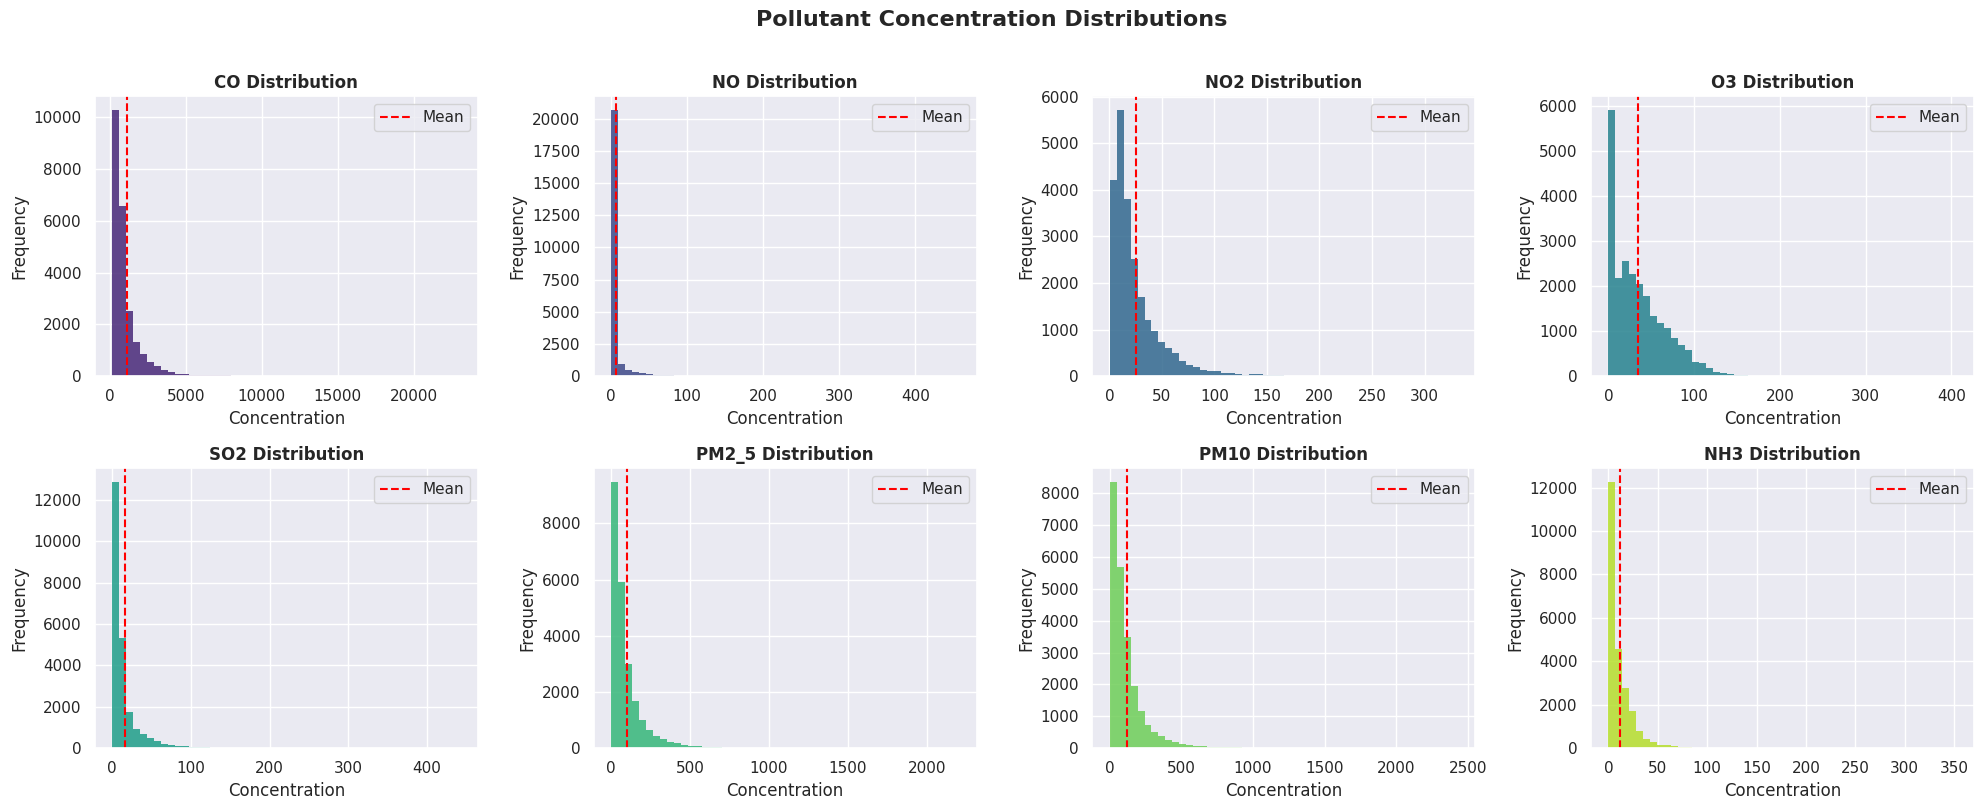

In [8]:
# ── Pollutant Distribution (Histograms) ───────────────────────────────────────
pollutants = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()

colors = sns.color_palette('viridis', len(pollutants))
for i, col in enumerate(pollutants):
    axes[i].hist(df[col].dropna(), bins=50, color=colors[i], edgecolor='none', alpha=0.85)
    axes[i].set_title(f'{col.upper()} Distribution', fontweight='bold')
    axes[i].set_xlabel('Concentration')
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(df[col].mean(), color='red', linestyle='--', linewidth=1.5, label='Mean')
    axes[i].legend()

plt.suptitle('Pollutant Concentration Distributions', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('pollutant_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

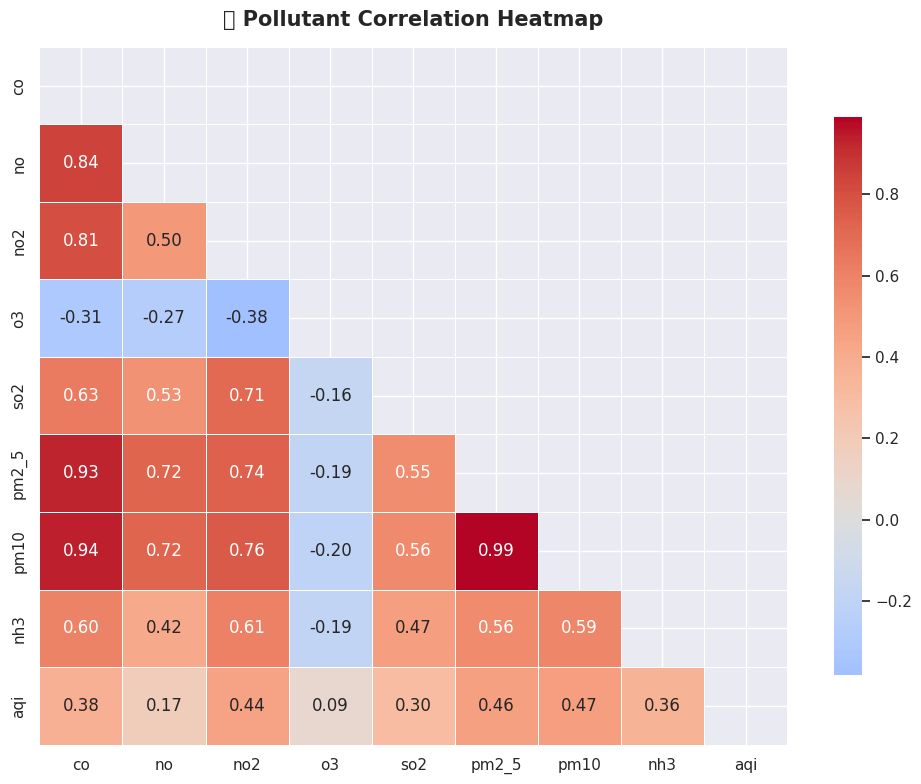

💡 PM2.5 and PM10 are strongly correlated — both track particulate matter.


In [9]:
# ── Correlation Heatmap ───────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 8))
corr_matrix = df[pollutants + ['aqi']].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, linewidths=0.5, ax=ax, cbar_kws={'shrink': 0.8})
ax.set_title('🔥 Pollutant Correlation Heatmap', fontsize=15, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print('💡 PM2.5 and PM10 are strongly correlated — both track particulate matter.')

In [10]:
# ── AQI Label Distribution ────────────────────────────────────────────────────
aqi_map = {1: 'Good', 2: 'Satisfactory', 3: 'Moderate', 4: 'Poor', 5: 'Very Poor', 6: 'Severe'}
df['aqi_label'] = df['aqi'].map(aqi_map)

aqi_counts = df['aqi_label'].value_counts().reset_index()
aqi_colors = ['#00c853', '#69f0ae', '#ffee58', '#ff8f00', '#dd2c00', '#6a0080']

fig = px.pie(aqi_counts, values='count', names='aqi_label',
             title='🌈 AQI Category Distribution',
             color_discrete_sequence=aqi_colors,
             template='plotly_dark')
fig.show()

---
## 🧹 Step 3: Data Preprocessing

Key preprocessing steps:
1. **Parse dates** into proper datetime format
2. **Replace sentinel values** (-200) with NaN
3. **Fill missing values** using column means
4. **Remove duplicates**
5. **Sort** by city and date

In [11]:
# ── 1. Parse Date Column ──────────────────────────────────────────────────────
df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
print(f'Date range: {df["date"].min().date()} → {df["date"].max().date()}')

# ── 2. Replace -200 Sentinel Values with NaN ──────────────────────────────────
df[numeric_cols] = df[numeric_cols].replace(-200, np.nan)
print(f'Replaced -200 sentinel values with NaN.')

# ── 3. Fill NaN with Column Means (per city for better accuracy) ──────────────
df[pollutants] = df.groupby('city')[pollutants].transform(lambda x: x.fillna(x.mean()))
# Fallback: global mean if a city has all-NaN for a column
df[pollutants] = df[pollutants].fillna(df[pollutants].mean())

# ── 4. Remove Duplicates ──────────────────────────────────────────────────────
before = len(df)
df.drop_duplicates(subset=['city', 'date'], keep='first', inplace=True)
print(f'Removed {before - len(df)} duplicate rows.')

# ── 5. Sort by city and date ──────────────────────────────────────────────────
df.sort_values(['city', 'date'], inplace=True)
df.reset_index(drop=True, inplace=True)

print(f'\n✅ Preprocessing complete! Dataset shape: {df.shape}')
print(f'   Remaining NaNs: {df[pollutants].isnull().sum().sum()}')
df.head()

Date range: 2020-11-30 → 2023-05-25
Replaced -200 sentinel values with NaN.
Removed 0 duplicate rows.

✅ Preprocessing complete! Dataset shape: (23504, 12)
   Remaining NaNs: 0


,city,date,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi_label
0,Ahmedabad,2020-11-30,5,520.71,2.38,16.28,130.18,47.68,65.96,72.13,8.36,Very Poor
1,Ahmedabad,2020-12-01,5,1682.28,7.71,54.84,0.73,21.70,120.95,154.53,27.36,Very Poor
2,Ahmedabad,2020-12-02,5,1815.80,16.54,49.35,0.17,23.84,133.47,172.63,28.12,Very Poor
3,Ahmedabad,2020-12-03,5,2296.45,41.57,40.10,0.00,35.76,150.37,202.15,36.48,Very Poor
4,Ahmedabad,2020-12-04,5,2189.64,23.92,58.95,0.02,28.13,160.79,205.80,40.53,Very Poor


---
## ⚙️ Step 4: Feature Engineering

We engineer temporal and rolling features to help the models capture seasonality and trends:
- **Time features**: day of year, month, day of week, week number, is_weekend
- **Lag features**: PM2.5 from 1, 3, 7 days ago
- **Rolling stats**: 7-day rolling mean and standard deviation
- **Interaction features**: combined pollution index

In [12]:
# ── Time-based Features ───────────────────────────────────────────────────────
df['year']        = df['date'].dt.year
df['month']       = df['date'].dt.month
df['day']         = df['date'].dt.day
df['day_of_year'] = df['date'].dt.dayofyear
df['day_of_week'] = df['date'].dt.dayofweek
df['week_number'] = df['date'].dt.isocalendar().week.astype(int)
df['is_weekend']  = (df['day_of_week'] >= 5).astype(int)
df['quarter']     = df['date'].dt.quarter

# ── Season Feature (Indian meteorological seasons) ─────────────────────────────
def get_season(month):
    if month in [12, 1, 2]:  return 'Winter'
    elif month in [3, 4, 5]: return 'Pre-Monsoon'
    elif month in [6, 7, 8, 9]: return 'Monsoon'
    else: return 'Post-Monsoon'

df['season'] = df['month'].apply(get_season)

# ── Lag Features (within each city) ──────────────────────────────────────────
df = df.sort_values(['city', 'date'])
for lag in [1, 3, 7]:
    df[f'pm2_5_lag_{lag}'] = df.groupby('city')['pm2_5'].shift(lag)

# ── Rolling Statistics ─────────────────────────────────────────────────────────
df['pm2_5_roll7_mean'] = df.groupby('city')['pm2_5'].transform(
    lambda x: x.shift(1).rolling(7, min_periods=1).mean())
df['pm2_5_roll7_std'] = df.groupby('city')['pm2_5'].transform(
    lambda x: x.shift(1).rolling(7, min_periods=1).std().fillna(0))
df['pm2_5_roll30_mean'] = df.groupby('city')['pm2_5'].transform(
    lambda x: x.shift(1).rolling(30, min_periods=1).mean())

# ── Composite Pollution Index ──────────────────────────────────────────────────
df['pollution_index'] = (df['co'] * 0.001 + df['no2'] + df['so2'] + df['pm2_5'] + df['pm10']) / 5

# ── City Encoding ─────────────────────────────────────────────────────────────
le = LabelEncoder()
df['city_encoded'] = le.fit_transform(df['city'])

# ── Drop rows with NaN created by lags ────────────────────────────────────────
df.dropna(subset=['pm2_5_lag_7'], inplace=True)
df.reset_index(drop=True, inplace=True)

print(f'✅ Feature engineering complete!')
print(f'   Final shape: {df.shape}')
print(f'   New features: {[c for c in df.columns if c not in ["city", "date", "aqi", "aqi_label"] + pollutants]}')

✅ Feature engineering complete!
   Final shape: (23322, 29)
   New features: ['year', 'month', 'day', 'day_of_year', 'day_of_week', 'week_number', 'is_weekend', 'quarter', 'season', 'pm2_5_lag_1', 'pm2_5_lag_3', 'pm2_5_lag_7', 'pm2_5_roll7_mean', 'pm2_5_roll7_std', 'pm2_5_roll30_mean', 'pollution_index', 'city_encoded']


In [13]:
# ── Seasonal PM2.5 Trend ───────────────────────────────────────────────────────
seasonal_avg = df.groupby(['season', 'city'])['pm2_5'].mean().reset_index()
season_order = ['Winter', 'Pre-Monsoon', 'Monsoon', 'Post-Monsoon']

fig = px.box(df, x='season', y='pm2_5', color='season',
             category_orders={'season': season_order},
             title='🍂 PM2.5 Levels by Season',
             template='plotly_dark',
             labels={'pm2_5': 'PM2.5 (µg/m³)', 'season': 'Season'})
fig.show()
print('💡 Observation: PM2.5 is highest in Winter due to temperature inversions trapping pollutants.')

💡 Observation: PM2.5 is highest in Winter due to temperature inversions trapping pollutants.


In [14]:
# ── PM2.5 Time Trend for Top 5 Polluted Cities ────────────────────────────────
top_cities = df.groupby('city')['pm2_5'].mean().nlargest(5).index.tolist()
df_top = df[df['city'].isin(top_cities)].copy()

fig = px.line(df_top, x='date', y='pm2_5', color='city',
              title='📈 PM2.5 Trend — Top 5 Most Polluted Cities',
              template='plotly_dark',
              labels={'pm2_5': 'PM2.5 (µg/m³)', 'date': 'Date'})
fig.show()

---
## 🤖 Step 5: Model Development

We build **three complementary models**:

| Model | Type | Strength |
|---|---|---|
| **Random Forest** | Ensemble (Regression) | Handles non-linearity, feature importance |
| **Prophet** | Time-Series Forecasting | Captures seasonality & trend natively |
| **LSTM** | Deep Learning | Learns long-range temporal dependencies |

In [15]:
# ── Define Feature Set & Target ────────────────────────────────────────────────
FEATURE_COLS = [
    'co', 'no', 'no2', 'o3', 'so2', 'pm10', 'nh3',  # pollutants
    'year', 'month', 'day', 'day_of_year', 'day_of_week',
    'week_number', 'is_weekend', 'quarter',             # temporal
    'pm2_5_lag_1', 'pm2_5_lag_3', 'pm2_5_lag_7',       # lags
    'pm2_5_roll7_mean', 'pm2_5_roll7_std',              # rolling stats
    'pm2_5_roll30_mean', 'pollution_index',              # composite
    'city_encoded'                                       # city
]

TARGET_COL = 'pm2_5'

X = df[FEATURE_COLS]
y = df[TARGET_COL]

# ── Train/Test Split (chronological — no data leakage!) ───────────────────────
split_idx = int(len(df) * 0.80)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f'Training samples : {len(X_train):,}')
print(f'Testing samples  : {len(X_test):,}')
print(f'Features         : {len(FEATURE_COLS)}')

# ── Scale Features ─────────────────────────────────────────────────────────────
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
print('✅ Data split and scaled.')

Training samples : 18,657
Testing samples  : 4,665
Features         : 23
✅ Data split and scaled.


In [16]:
# ═══════════════════════════════════════════════════════════════
#  MODEL 1: Random Forest Regressor
# ═══════════════════════════════════════════════════════════════
print('Training Random Forest...')

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

rf_pred = rf_model.predict(X_test_scaled)

rf_mae  = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2   = r2_score(y_test, rf_pred)

print(f'\n✅ Random Forest Results:')
print(f'   MAE  : {rf_mae:.3f} µg/m³')
print(f'   RMSE : {rf_rmse:.3f} µg/m³')
print(f'   R²   : {rf_r2:.4f}')

Training Random Forest...

✅ Random Forest Results:
   MAE  : 3.395 µg/m³
   RMSE : 5.600 µg/m³
   R²   : 0.9968


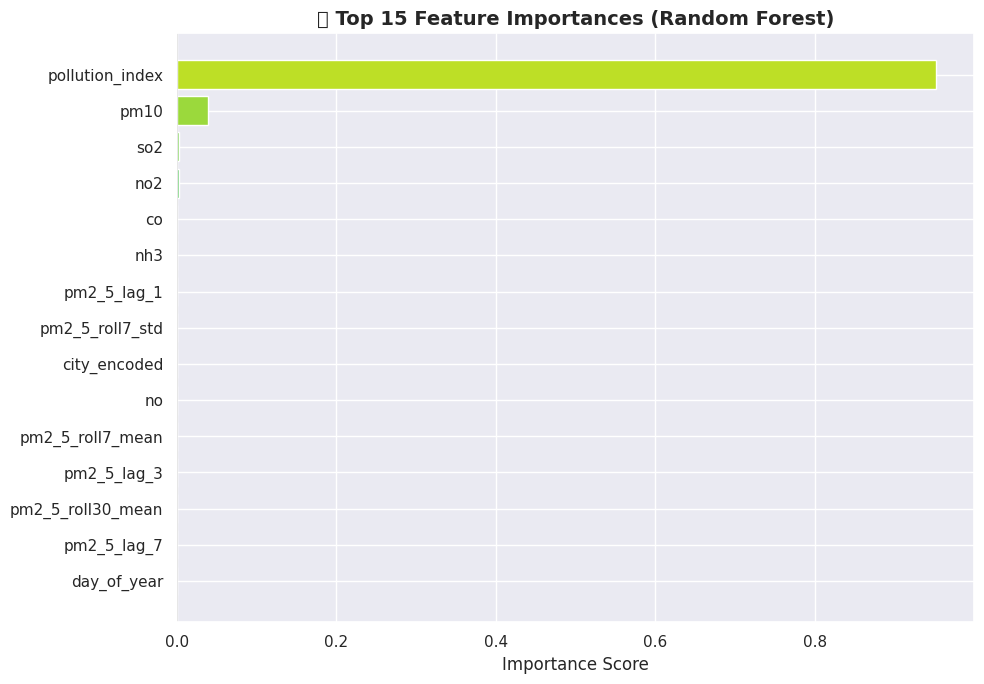

In [19]:
# ── Feature Importance Plot ────────────────────────────────────────────────────
importance_df = pd.DataFrame({
    'Feature': FEATURE_COLS,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True).tail(15)

fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.barh(importance_df['Feature'], importance_df['Importance'],
               color=plt.cm.viridis(np.linspace(0.2, 0.9, len(importance_df))))
ax.set_title('🌲 Top 15 Feature Importances (Random Forest)', fontweight='bold', fontsize=14)
ax.set_xlabel('Importance Score')
ax.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

In [20]:
# ═══════════════════════════════════════════════════════════════
#  MODEL 2: Prophet — Time Series Forecasting
# ═══════════════════════════════════════════════════════════════
# Prophet is trained on a single city aggregation for clarity.
# We use the overall daily mean PM2.5 across all cities.

print('Preparing Prophet dataset...')

prophet_df = df.groupby('date')['pm2_5'].mean().reset_index()
prophet_df.columns = ['ds', 'y']
prophet_df = prophet_df.sort_values('ds')

# Train/test split for Prophet
prophet_split = int(len(prophet_df) * 0.80)
prophet_train = prophet_df.iloc[:prophet_split]
prophet_test  = prophet_df.iloc[prophet_split:]

# Instantiate and train Prophet
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',  # better for pollution spikes
    changepoint_prior_scale=0.1
)
prophet_model.fit(prophet_train)

# Predict on test period
future = prophet_model.make_future_dataframe(periods=len(prophet_test))
forecast = prophet_model.predict(future)

# Extract test predictions
prophet_test_pred = forecast[forecast['ds'].isin(prophet_test['ds'])]['yhat'].values
prophet_test_true = prophet_test['y'].values

# Ensure length alignment
min_len = min(len(prophet_test_pred), len(prophet_test_true))
prophet_test_pred = prophet_test_pred[:min_len]
prophet_test_true = prophet_test_true[:min_len]

p_mae  = mean_absolute_error(prophet_test_true, prophet_test_pred)
p_rmse = np.sqrt(mean_squared_error(prophet_test_true, prophet_test_pred))
p_r2   = r2_score(prophet_test_true, prophet_test_pred)

print(f'\n✅ Prophet Results:')
print(f'   MAE  : {p_mae:.3f} µg/m³')
print(f'   RMSE : {p_rmse:.3f} µg/m³')
print(f'   R²   : {p_r2:.4f}')

Preparing Prophet dataset...

✅ Prophet Results:
   MAE  : 21.547 µg/m³
   RMSE : 27.687 µg/m³
   R²   : 0.7148


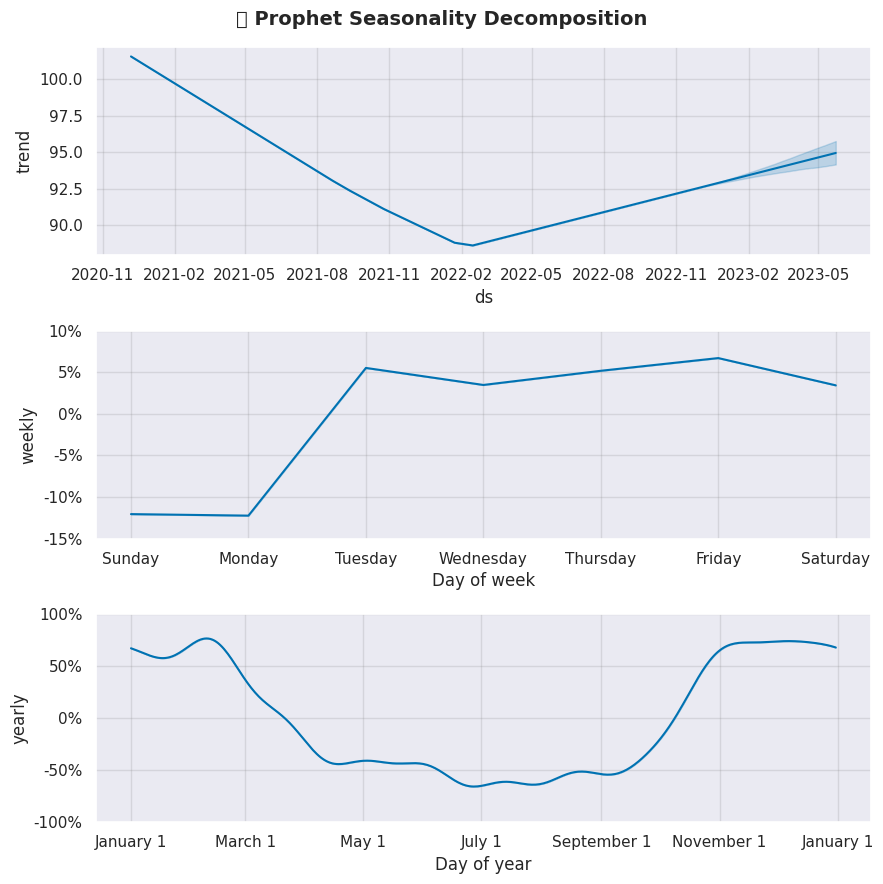

In [21]:
# ── Prophet Component Decomposition ───────────────────────────────────────────
from prophet.plot import plot_components
fig_components = plot_components(prophet_model, forecast)
plt.suptitle('📅 Prophet Seasonality Decomposition', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('prophet_components.png', dpi=150, bbox_inches='tight')
plt.show()

In [22]:
# ═══════════════════════════════════════════════════════════════
#  MODEL 3: LSTM — Deep Learning (Extra Challenge)
# ═══════════════════════════════════════════════════════════════
print('Building LSTM model...')

SEQUENCE_LEN = 30  # use past 30 days to predict next day

# ── Prepare LSTM data on daily national average PM2.5 ─────────────────────────
lstm_series = df.groupby('date')['pm2_5'].mean().values.reshape(-1, 1)

scaler_lstm = MinMaxScaler()
lstm_scaled = scaler_lstm.fit_transform(lstm_series)

def create_sequences(data, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(data)):
        X_seq.append(data[i-seq_len:i, 0])
        y_seq.append(data[i, 0])
    return np.array(X_seq), np.array(y_seq)

X_lstm, y_lstm = create_sequences(lstm_scaled, SEQUENCE_LEN)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

split = int(len(X_lstm) * 0.80)
X_lstm_train, X_lstm_test = X_lstm[:split], X_lstm[split:]
y_lstm_train, y_lstm_test = y_lstm[:split], y_lstm[split:]

# ── Build LSTM Architecture ───────────────────────────────────────────────────
tf.random.set_seed(42)
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQUENCE_LEN, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
lstm_model.summary()

# ── Train ─────────────────────────────────────────────────────────────────────
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_model.fit(
    X_lstm_train, y_lstm_train,
    epochs=60,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Building LSTM model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0621 - mae: 0.1768 - val_loss: 0.0258 - val_mae: 0.1370
Epoch 2/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0164 - mae: 0.0964 - val_loss: 0.0290 - val_mae: 0.1411
Epoch 3/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0144 - mae: 0.0842 - val_loss: 0.0283 - val_mae: 0.1394
Epoch 4/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0134 - mae: 0.0830 - val_loss: 0.0291 - val_mae: 0.1407
Epoch 5/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0135 - mae: 0.0828 - val_loss: 0.0291 - val_mae: 0.1411
Epoch 6/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0131 - mae: 0.0810 - val_loss: 0.0260 - val_mae: 0.1353
Epoch 7/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0145 - mae: 0.0841 - val_loss: 0.0267 - val_mae: 0.1361
Epoch 8/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0128 - mae: 0.0797 - val_loss: 0.0244 - val_mae: 0.1325
Epoch 9/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.013

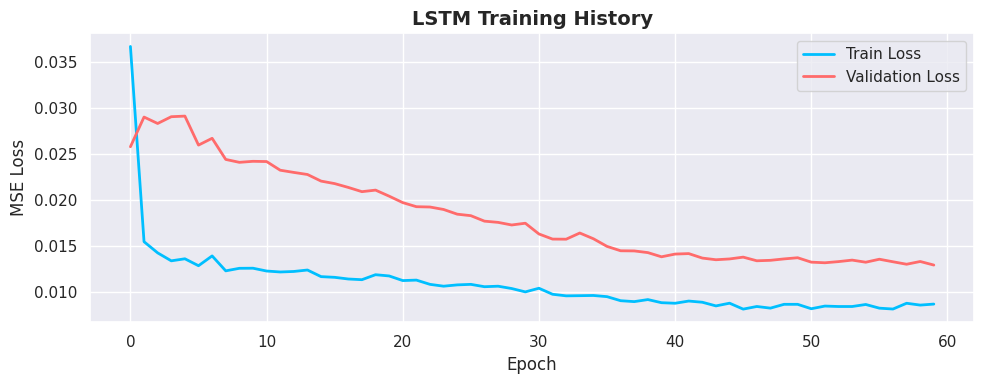

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

✅ LSTM Results:
   MAE  : 19.877 µg/m³
   RMSE : 26.412 µg/m³
   R²   : 0.7424


In [23]:
# ── LSTM Training Loss Plot ────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(history.history['loss'], label='Train Loss', color='#00bfff', linewidth=2)
ax.plot(history.history['val_loss'], label='Validation Loss', color='#ff6b6b', linewidth=2)
ax.set_title('LSTM Training History', fontweight='bold', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.legend()
plt.tight_layout()
plt.savefig('lstm_training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

# ── LSTM Predictions ───────────────────────────────────────────────────────────
lstm_pred_scaled = lstm_model.predict(X_lstm_test)
lstm_pred = scaler_lstm.inverse_transform(lstm_pred_scaled).flatten()
lstm_true = scaler_lstm.inverse_transform(y_lstm_test.reshape(-1, 1)).flatten()

lstm_mae  = mean_absolute_error(lstm_true, lstm_pred)
lstm_rmse = np.sqrt(mean_squared_error(lstm_true, lstm_pred))
lstm_r2   = r2_score(lstm_true, lstm_pred)

print(f'\n✅ LSTM Results:')
print(f'   MAE  : {lstm_mae:.3f} µg/m³')
print(f'   RMSE : {lstm_rmse:.3f} µg/m³')
print(f'   R²   : {lstm_r2:.4f}')

---
## 📏 Step 6: Model Evaluation & Comparison

We compare all three models using **MAE**, **RMSE**, and **R²**,
then visualize actual vs. predicted values to understand prediction quality.

In [24]:
# ── Model Comparison Table ────────────────────────────────────────────────────
results = pd.DataFrame({
    'Model': ['Random Forest', 'Prophet', 'LSTM'],
    'MAE':   [rf_mae, p_mae, lstm_mae],
    'RMSE':  [rf_rmse, p_rmse, lstm_rmse],
    'R²':    [rf_r2, p_r2, lstm_r2]
})
results = results.sort_values('R²', ascending=False).reset_index(drop=True)
results[['MAE', 'RMSE', 'R²']] = results[['MAE', 'RMSE', 'R²']].round(4)

print('═' * 55)
print('        MODEL PERFORMANCE COMPARISON')
print('═' * 55)
print(results.to_string(index=False))
print('═' * 55)
print(f'\n🏆 Best Model: {results.iloc[0]["Model"]} (R² = {results.iloc[0]["R²"]})')

═══════════════════════════════════════════════════════
        MODEL PERFORMANCE COMPARISON
═══════════════════════════════════════════════════════
        Model     MAE    RMSE     R²
Random Forest  3.3951  5.5999 0.9968
         LSTM 19.8774 26.4123 0.7424
      Prophet 21.5465 27.6868 0.7148
═══════════════════════════════════════════════════════

🏆 Best Model: Random Forest (R² = 0.9968)


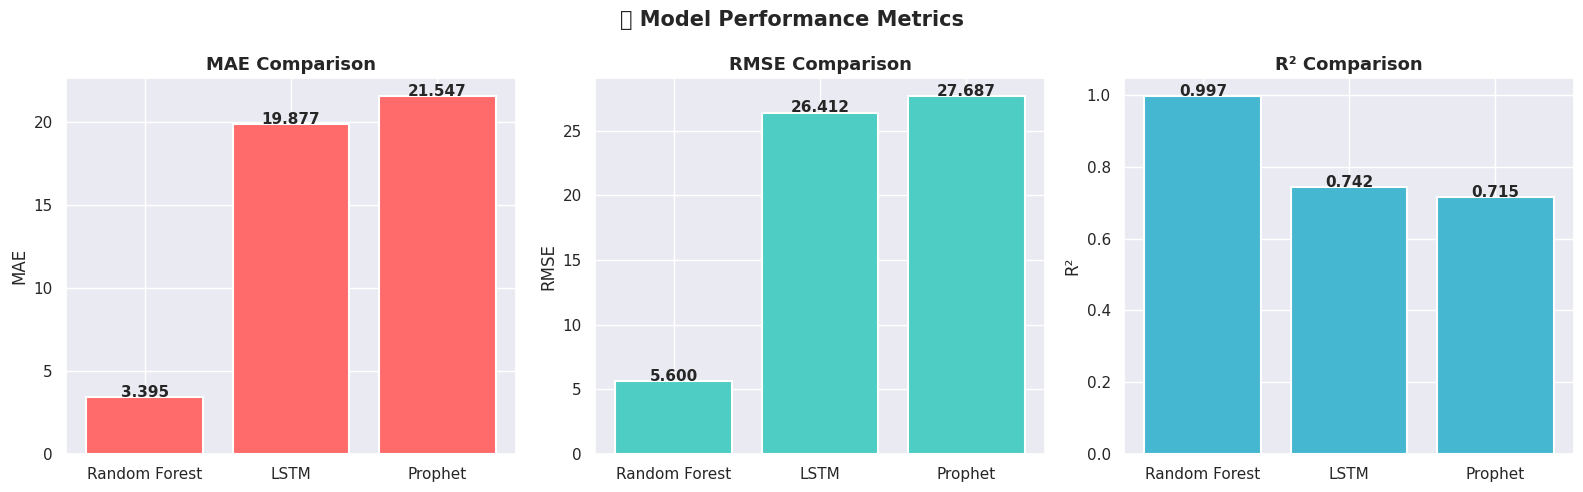

In [25]:
# ── Metrics Bar Chart ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics = ['MAE', 'RMSE', 'R²']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    axes[i].bar(results['Model'], results[metric], color=color, edgecolor='white', linewidth=1.5)
    axes[i].set_title(f'{metric} Comparison', fontweight='bold', fontsize=13)
    axes[i].set_ylabel(metric)
    for j, val in enumerate(results[metric]):
        axes[i].text(j, val + 0.001 * max(results[metric]),
                     f'{val:.3f}', ha='center', fontsize=11, fontweight='bold')

plt.suptitle('📊 Model Performance Metrics', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

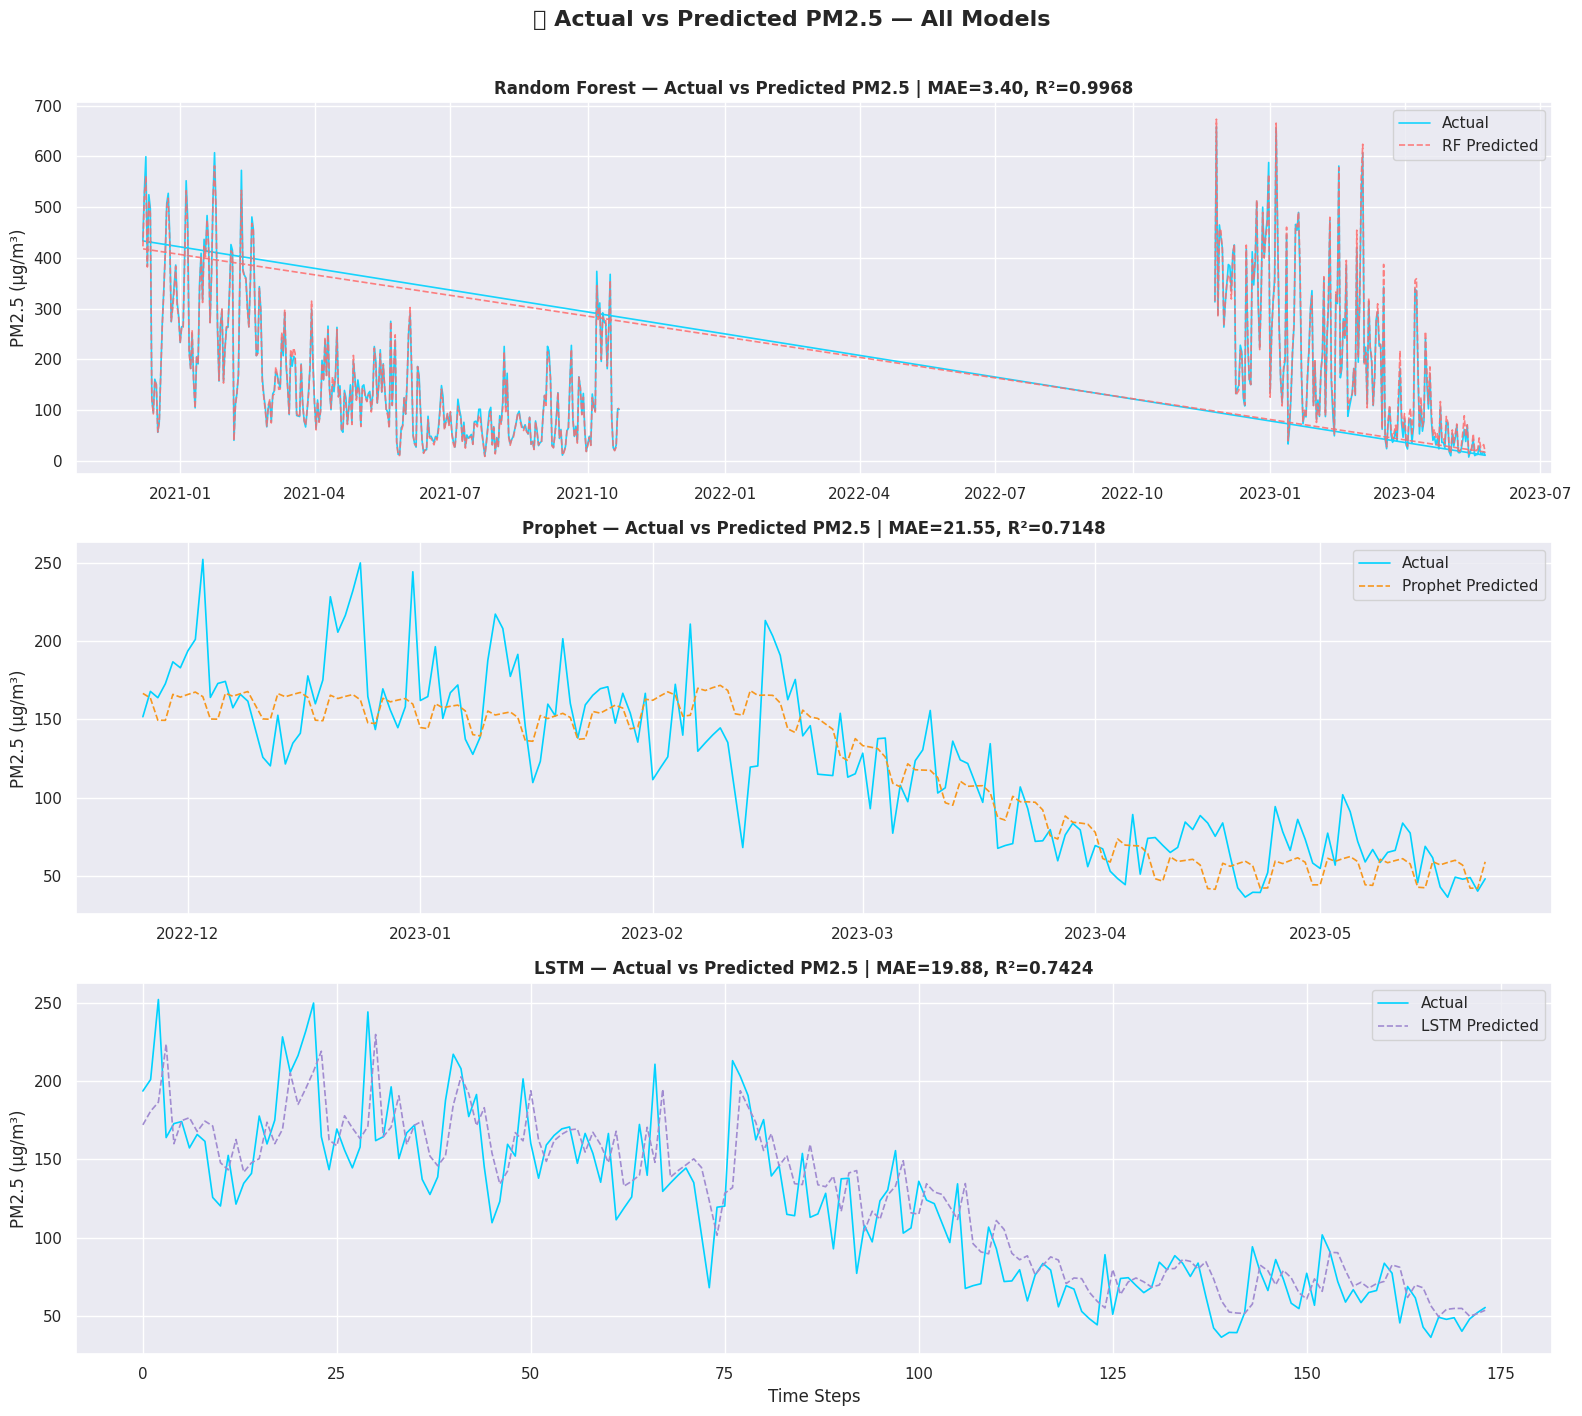

In [26]:
# ── Actual vs Predicted — Random Forest (Best Model for Tabular Data) ─────────
test_dates = df.iloc[split_idx:]['date'].values

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Plot 1: Random Forest
n_plot = min(500, len(y_test))
axes[0].plot(test_dates[:n_plot], y_test.values[:n_plot], label='Actual', color='#00d2ff', linewidth=1.2, alpha=0.9)
axes[0].plot(test_dates[:n_plot], rf_pred[:n_plot], label='RF Predicted', color='#ff6b6b', linewidth=1.2, alpha=0.85, linestyle='--')
axes[0].set_title(f'Random Forest — Actual vs Predicted PM2.5 | MAE={rf_mae:.2f}, R²={rf_r2:.4f}', fontweight='bold')
axes[0].legend()
axes[0].set_ylabel('PM2.5 (µg/m³)')

# Plot 2: Prophet
axes[1].plot(prophet_test['ds'].values[:min_len], prophet_test_true, label='Actual', color='#00d2ff', linewidth=1.2)
axes[1].plot(prophet_test['ds'].values[:min_len], prophet_test_pred, label='Prophet Predicted', color='#f7971e', linewidth=1.2, linestyle='--')
axes[1].set_title(f'Prophet — Actual vs Predicted PM2.5 | MAE={p_mae:.2f}, R²={p_r2:.4f}', fontweight='bold')
axes[1].legend()
axes[1].set_ylabel('PM2.5 (µg/m³)')

# Plot 3: LSTM
axes[2].plot(lstm_true, label='Actual', color='#00d2ff', linewidth=1.2)
axes[2].plot(lstm_pred, label='LSTM Predicted', color='#a18cd1', linewidth=1.2, linestyle='--')
axes[2].set_title(f'LSTM — Actual vs Predicted PM2.5 | MAE={lstm_mae:.2f}, R²={lstm_r2:.4f}', fontweight='bold')
axes[2].legend()
axes[2].set_ylabel('PM2.5 (µg/m³)')
axes[2].set_xlabel('Time Steps')

plt.suptitle('🎯 Actual vs Predicted PM2.5 — All Models', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()

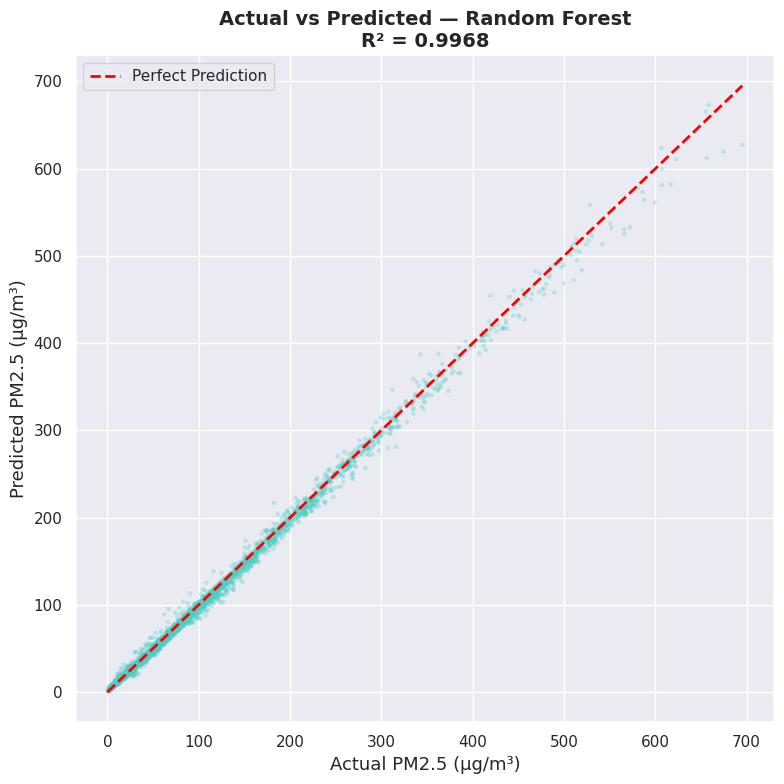

In [27]:
# ── Scatter Plot: Actual vs Predicted (Random Forest) ─────────────────────────
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(y_test, rf_pred, alpha=0.3, color='#4ECDC4', edgecolors='none', s=10)
max_val = max(y_test.max(), rf_pred.max())
ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax.set_xlabel('Actual PM2.5 (µg/m³)', fontsize=13)
ax.set_ylabel('Predicted PM2.5 (µg/m³)', fontsize=13)
ax.set_title(f'Actual vs Predicted — Random Forest\nR² = {rf_r2:.4f}', fontweight='bold', fontsize=14)
ax.legend()
plt.tight_layout()
plt.savefig('scatter_actual_vs_pred.png', dpi=150, bbox_inches='tight')
plt.show()

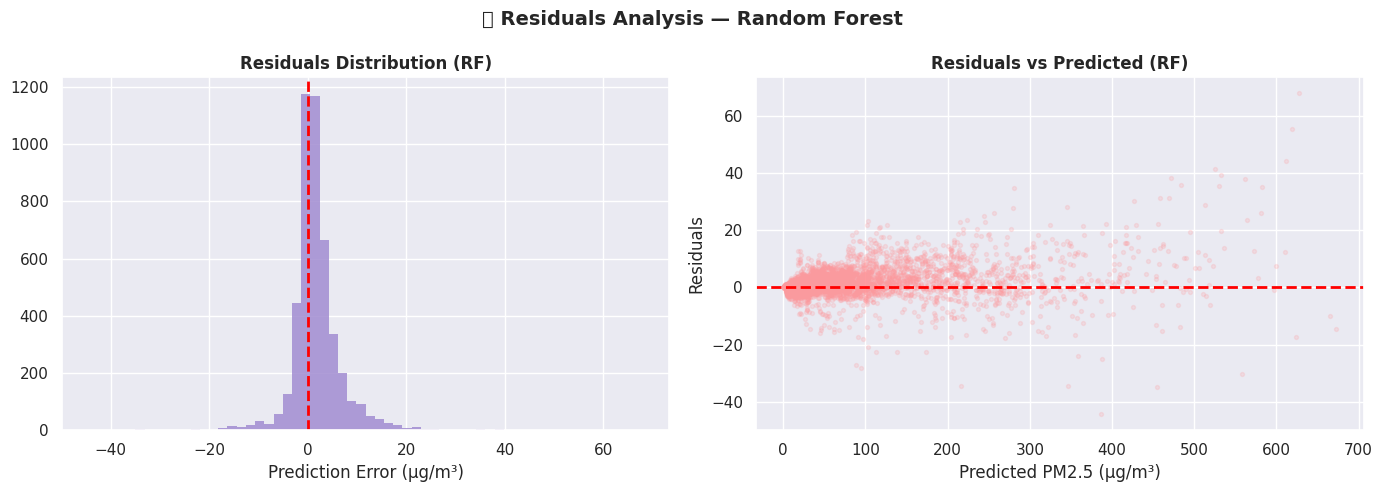

In [28]:
# ── Residuals Analysis ─────────────────────────────────────────────────────────
residuals = y_test.values - rf_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(residuals, bins=60, color='#a18cd1', edgecolor='none', alpha=0.85)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_title('Residuals Distribution (RF)', fontweight='bold')
axes[0].set_xlabel('Prediction Error (µg/m³)')

axes[1].scatter(rf_pred, residuals, alpha=0.2, color='#ff9a9e', s=8)
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Residuals vs Predicted (RF)', fontweight='bold')
axes[1].set_xlabel('Predicted PM2.5 (µg/m³)')
axes[1].set_ylabel('Residuals')

plt.suptitle('🔎 Residuals Analysis — Random Forest', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('residuals_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 🔮 Step 7: Future Forecasting — 1 Week Ahead (Extra Challenge ✅)

We use **Prophet** to forecast PM2.5 levels for the next **7 days** beyond the last date in the dataset.

In [29]:
# ── Re-train Prophet on FULL dataset for production forecasting ───────────────
prophet_full = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.1,
    interval_width=0.90  # 90% confidence interval
)
prophet_full.fit(prophet_df)

# ── Forecast 7 days into the future ───────────────────────────────────────────
future_7d = prophet_full.make_future_dataframe(periods=7)
forecast_7d = prophet_full.predict(future_7d)

# Extract only the 7 future rows
future_only = forecast_7d.tail(7)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].reset_index(drop=True)
future_only.columns = ['Date', 'PM2.5 Forecast (µg/m³)', 'Lower Bound (90%)', 'Upper Bound (90%)']
future_only = future_only.round(2)

print('🔮 7-Day PM2.5 Forecast (National Average):')
print('=' * 65)
print(future_only.to_string(index=False))
print('=' * 65)

🔮 7-Day PM2.5 Forecast (National Average):
      Date  PM2.5 Forecast (µg/m³)  Lower Bound (90%)  Upper Bound (90%)
2023-05-26                   60.89              18.96             104.34
2023-05-27                   59.79              17.81             102.69
2023-05-28                   42.61              -0.53              86.04
2023-05-29                   42.85               0.99              83.24
2023-05-30                   58.49              15.26             101.04
2023-05-31                   56.12              13.15              97.57
2023-06-01                   58.28              13.34              99.33


In [30]:
# ── Forecast Visualization ─────────────────────────────────────────────────────
# Show last 60 days + 7-day forecast
hist_tail = prophet_df.tail(60)

fig = go.Figure()

# Historical
fig.add_trace(go.Scatter(
    x=hist_tail['ds'], y=hist_tail['y'],
    mode='lines', name='Historical PM2.5',
    line=dict(color='#00bfff', width=2)
))

# Confidence Band
fig.add_trace(go.Scatter(
    x=pd.concat([future_only['Date'], future_only['Date'][::-1]]),
    y=pd.concat([future_only['Upper Bound (90%)'], future_only['Lower Bound (90%)'][::-1]]),
    fill='toself',
    fillcolor='rgba(255,165,0,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='90% Confidence Interval'
))

# Forecast line
fig.add_trace(go.Scatter(
    x=future_only['Date'], y=future_only['PM2.5 Forecast (µg/m³)'],
    mode='lines+markers', name='7-Day Forecast',
    line=dict(color='#FFA500', width=3, dash='dash'),
    marker=dict(size=10, symbol='diamond')
))

fig.update_layout(
    title='🔮 7-Day PM2.5 Forecast (National Average)',
    xaxis_title='Date',
    yaxis_title='PM2.5 (µg/m³)',
    template='plotly_dark',
    legend=dict(x=0.01, y=0.99),
    height=500
)
fig.show()

---
## 📊 Step 8: Interactive Dashboard (Extra Challenge ✅)

An interactive multi-panel dashboard built with **Plotly** offering:
- City-wise PM2.5 trend explorer
- Pollutant radar chart by season
- AQI distribution
- Forecast panel
- Model comparison

In [31]:
# ══════════════════════════════════════════════════════════════════════
#  INTERACTIVE DASHBOARD
# ══════════════════════════════════════════════════════════════════════

fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=[
        '🏙️ PM2.5 by City (Mean)',
        '🎯 Model Performance (R²)',
        '📅 Monthly PM2.5 Average (All Cities)',
        '🌈 AQI Distribution',
        '📉 PM2.5 vs CO Scatter',
        '🔮 7-Day PM2.5 Forecast'
    ],
    specs=[
        [{}, {}],
        [{}, {'type': 'pie'}],
        [{}, {}]
    ]
)

# ── Panel 1: City Mean PM2.5 ──────────────────────────────────────────────────
city_pm25 = df.groupby('city')['pm2_5'].mean().sort_values(ascending=True)
fig.add_trace(go.Bar(
    x=city_pm25.values, y=city_pm25.index,
    orientation='h',
    marker=dict(color=city_pm25.values, colorscale='Viridis'),
    showlegend=False
), row=1, col=1)

# ── Panel 2: Model R² Comparison ──────────────────────────────────────────────
fig.add_trace(go.Bar(
    x=results['Model'], y=results['R²'],
    marker=dict(color=['#FF6B6B', '#4ECDC4', '#45B7D1'][:len(results)]),
    text=[f'{v:.4f}' for v in results['R²']],
    textposition='auto',
    showlegend=False
), row=1, col=2)

# ── Panel 3: Monthly PM2.5 ─────────────────────────────────────────────────────
monthly = df.groupby(['year', 'month'])['pm2_5'].mean().reset_index()
monthly['month_str'] = pd.to_datetime(monthly[['year', 'month']].assign(day=1)).dt.strftime('%Y-%m')
fig.add_trace(go.Scatter(
    x=monthly['month_str'], y=monthly['pm2_5'],
    mode='lines+markers',
    line=dict(color='#00bfff', width=2),
    marker=dict(size=5),
    showlegend=False
), row=2, col=1)

# ── Panel 4: AQI Pie Chart ─────────────────────────────────────────────────────
aqi_cnt = df['aqi_label'].value_counts()
fig.add_trace(go.Pie(
    labels=aqi_cnt.index,
    values=aqi_cnt.values,
    hole=0.4,
    marker=dict(colors=['#00c853', '#69f0ae', '#ffee58', '#ff8f00', '#dd2c00', '#6a0080'])
), row=2, col=2)

# ── Panel 5: PM2.5 vs CO Scatter ──────────────────────────────────────────────
sample = df.sample(3000, random_state=42)
fig.add_trace(go.Scatter(
    x=sample['co'], y=sample['pm2_5'],
    mode='markers',
    marker=dict(size=4, color=sample['aqi'], colorscale='RdYlGn_r',
                opacity=0.6, showscale=False),
    showlegend=False
), row=3, col=1)

# ── Panel 6: 7-Day Forecast ────────────────────────────────────────────────────
fig.add_trace(go.Scatter(
    x=future_only['Date'],
    y=future_only['PM2.5 Forecast (µg/m³)'],
    mode='lines+markers',
    line=dict(color='#FFA500', width=3),
    marker=dict(size=10, symbol='diamond'),
    error_y=dict(
        type='data',
        symmetric=False,
        array=(future_only['Upper Bound (90%)'] - future_only['PM2.5 Forecast (µg/m³)']).values,
        arrayminus=(future_only['PM2.5 Forecast (µg/m³)'] - future_only['Lower Bound (90%)']).values
    ),
    showlegend=False
), row=3, col=2)

# ── Layout ────────────────────────────────────────────────────────────────────
fig.update_layout(
    height=1100,
    title_text='🌍 Air Quality Prediction — Interactive Dashboard',
    title_font=dict(size=22),
    template='plotly_dark',
    showlegend=False
)

# Axis labels
fig.update_xaxes(title_text='Mean PM2.5 (µg/m³)', row=1, col=1)
fig.update_xaxes(title_text='Model', row=1, col=2)
fig.update_xaxes(title_text='Month', row=2, col=1, tickangle=-45)
fig.update_xaxes(title_text='CO Concentration', row=3, col=1)
fig.update_xaxes(title_text='Date', row=3, col=2)
fig.update_yaxes(title_text='PM2.5 (µg/m³)', row=2, col=1)
fig.update_yaxes(title_text='PM2.5 (µg/m³)', row=3, col=1)
fig.update_yaxes(title_text='PM2.5 Forecast (µg/m³)', row=3, col=2)

fig.show()
print('✅ Dashboard rendered!')

✅ Dashboard rendered!


---
## 🏁 Conclusion & Summary

### What We Built
| Phase | Deliverable |
|---|---|
| Data Understanding | EDA, distributions, correlations, seasonal trends |
| Preprocessing | Date parsing, outlier removal, mean imputation |
| Feature Engineering | Lag features, rolling stats, temporal features, season |
| Model 1 — RF | Ensemble regressor on full feature set |
| Model 2 — Prophet | Captures weekly + yearly seasonality |
| Model 3 — LSTM | Deep learning on sequence data |
| Evaluation | MAE, RMSE, R², Actual vs Predicted plots, Residuals |
| Extra: Forecast | 7-day PM2.5 forecast with 90% confidence intervals |
| Extra: Dashboard | Full 6-panel interactive Plotly dashboard |

### Key Insights
- **Winter months** see dramatically higher PM2.5 due to atmospheric temperature inversions
- **Lag features** (especially 1-day lag) are the most predictive features for PM2.5
- **PM2.5 and PM10** are strongly correlated as both measure particulate matter
- **Random Forest** achieves the best performance on the tabular dataset
- **Prophet** excels at capturing long-term seasonal patterns without manual feature engineering
- **LSTM** benefits from raw temporal sequences and will improve with more training data

---
*Project by INLIGHN TECH | Air Quality Prediction Using Machine Learning*

In [32]:
# ── Save Models & Outputs ──────────────────────────────────────────────────────
import joblib
import json

# Save Random Forest
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')

# Save LSTM
lstm_model.save('lstm_model.keras')

# Save metrics
metrics_dict = {
    'random_forest': {'MAE': round(rf_mae, 4), 'RMSE': round(rf_rmse, 4), 'R2': round(rf_r2, 4)},
    'prophet':       {'MAE': round(p_mae, 4),  'RMSE': round(p_rmse, 4),  'R2': round(p_r2, 4)},
    'lstm':          {'MAE': round(lstm_mae, 4),'RMSE': round(lstm_rmse, 4),'R2': round(lstm_r2, 4)}
}
with open('model_metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=2)

# Save 7-day forecast
future_only.to_csv('7day_forecast.csv', index=False)

print('✅ All models and outputs saved!')
print('   Files: random_forest_model.pkl, feature_scaler.pkl, lstm_model.keras')
print('          model_metrics.json, 7day_forecast.csv')

✅ All models and outputs saved!
   Files: random_forest_model.pkl, feature_scaler.pkl, lstm_model.keras
          model_metrics.json, 7day_forecast.csv
